In [1]:
import ipdb
import torch
import torchvision

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
import numpy as np
import matplotlib.pyplot as plt

import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid

seed_everything(42, workers=True)
device ="cuda"

C:\Users\maxsa\anaconda3\envs\dl\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\maxsa\anaconda3\envs\dl\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


In [2]:
batch_size = 4*8
num_classes = 10
image_size = 28
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def one_hot(data):
    encoding  = np.zeros((len(data), num_classes))
    for ind in range(len(data)):
        encoding[ind,data[ind]-1] = 1
    return encoding

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./dataset/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./dataset/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size)

In [10]:
#Formula for ConvTranspose:
# Output Shape = (n-1) * (s) - (2p) + (dilation) * (f -1) + (o/p padding) + 1

latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16


    nn.ConvTranspose2d(128, 1, kernel_size=2, stride=2, padding=2, bias=False),
    nn.Tanh()
    # out: 1 x 28 x 28
).to(device)

In [11]:

class red_dim(nn.Module):
    def forward(self, input):
        return torch.squeeze(input, axis=-1)
reduce_dim = red_dim()
discriminator = nn.Sequential(
    # in: 1 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(64, 32, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    # red_dim(),
    nn.Sigmoid()).to(device)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1])


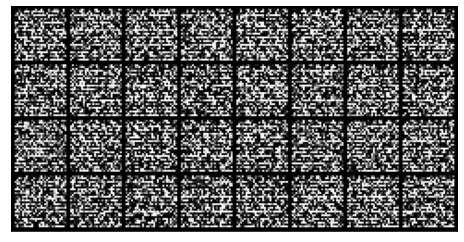

In [9]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

xb = torch.randn(batch_size, 1,28,28) # inp image
disc = discriminator(xb)
print(disc.shape)
show_images(disc)

In [12]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [13]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [14]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors).to(device)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [15]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


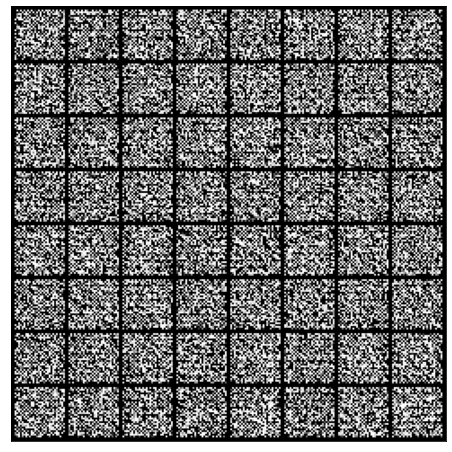

In [16]:
save_samples(0, fixed_latent)

In [17]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)


In [19]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            # Train discriminator
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        # fixed_latent.get_device()
        # generator.get_device()
        # ipdb.set_trace()
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [20]:
lr = 0.0002
epochs = 60

history = fit(epochs, lr)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 4.7756, loss_d: 0.0446, real_score: 0.9850, fake_score: 0.0284
Saving generated-images-0001.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 4.9032, loss_d: 0.0576, real_score: 0.9970, fake_score: 0.0510
Saving generated-images-0002.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 5.5169, loss_d: 0.0230, real_score: 0.9803, fake_score: 0.0026
Saving generated-images-0003.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 3.5724, loss_d: 0.1018, real_score: 0.9713, fake_score: 0.0632
Saving generated-images-0004.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 4.5564, loss_d: 0.0166, real_score: 0.9952, fake_score: 0.0116
Saving generated-images-0005.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 5.4570, loss_d: 0.1083, real_score: 0.9835, fake_score: 0.0799
Saving generated-images-0006.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 8.5165, loss_d: 0.1831, real_score: 0.8566, fake_score: 0.0014
Saving generated-images-0007.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 5.9858, loss_d: 0.0659, real_score: 0.9469, fake_score: 0.0097
Saving generated-images-0008.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 5.9902, loss_d: 0.0088, real_score: 0.9977, fake_score: 0.0064
Saving generated-images-0009.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 5.6691, loss_d: 0.1294, real_score: 0.9999, fake_score: 0.1158
Saving generated-images-0010.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 3.0761, loss_d: 0.1973, real_score: 0.8561, fake_score: 0.0264
Saving generated-images-0011.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 3.8954, loss_d: 0.4782, real_score: 0.8705, fake_score: 0.2451
Saving generated-images-0012.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 4.9206, loss_d: 0.0182, real_score: 0.9963, fake_score: 0.0140
Saving generated-images-0013.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 4.6211, loss_d: 0.0513, real_score: 0.9998, fake_score: 0.0479
Saving generated-images-0014.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 2.5535, loss_d: 0.0141, real_score: 0.9930, fake_score: 0.0070
Saving generated-images-0015.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 2.9202, loss_d: 0.6133, real_score: 0.9352, fake_score: 0.3524
Saving generated-images-0016.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 6.3009, loss_d: 0.0502, real_score: 0.9809, fake_score: 0.0277
Saving generated-images-0017.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 3.7908, loss_d: 0.0358, real_score: 0.9988, fake_score: 0.0324
Saving generated-images-0018.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 2.5186, loss_d: 0.1058, real_score: 0.9335, fake_score: 0.0307
Saving generated-images-0019.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 6.4930, loss_d: 0.0536, real_score: 0.9980, fake_score: 0.0494
Saving generated-images-0020.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 7.1618, loss_d: 0.0950, real_score: 0.9204, fake_score: 0.0002
Saving generated-images-0021.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 8.6739, loss_d: 0.0120, real_score: 0.9883, fake_score: 0.0001
Saving generated-images-0022.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.4489, loss_d: 0.1992, real_score: 0.9909, fake_score: 0.1600
Saving generated-images-0023.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 11.0353, loss_d: 0.0157, real_score: 0.9869, fake_score: 0.0023
Saving generated-images-0024.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 3.3614, loss_d: 0.0236, real_score: 0.9879, fake_score: 0.0112
Saving generated-images-0025.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 5.8293, loss_d: 0.0394, real_score: 0.9855, fake_score: 0.0230
Saving generated-images-0026.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 5.0540, loss_d: 0.0632, real_score: 0.9423, fake_score: 0.0024
Saving generated-images-0027.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 5.7087, loss_d: 0.1529, real_score: 0.9972, fake_score: 0.1304
Saving generated-images-0028.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 5.2357, loss_d: 0.0427, real_score: 0.9593, fake_score: 0.0002
Saving generated-images-0029.png


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 7.1756, loss_d: 0.0238, real_score: 0.9992, fake_score: 0.0217
Saving generated-images-0030.png


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# TODO: